# Testing using MIMIC for SweDS project


https://mimic.mit.edu/docs/iv/about/

## Helpful links for later:

https://mimic.mit.edu/docs/gettingstarted/cloud/request/

https://mimic.mit.edu/docs/gettingstarted/cloud/bigquery/

https://github.com/MIT-LCP/mimic-code/blob/main/mimic-iv/buildmimic/bigquery/README.md

https://physionet.org/settings/cloud/

## Setup & Loading Data

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

In [2]:
from google.colab import userdata
your_physionet_username = userdata.get('username')
your_physionet_password = userdata.get('password')

from google.colab import auth
auth.authenticate_user()

from google.cloud import bigquery
client = bigquery.Client(project='swe-ds-proj-eas') #my personal proj name


In [ ]:
#!pip install --quiet --upgrade google-cloud-bigquery


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 239.1/239.1 kB 4.4 MB/s eta 0:00:00


In [3]:
# SQL query to get admissions with hemorrhage diagnoses
query_hemorrhage_admissions = """
-- Get admissions with hemorrhage diagnoses
SELECT DISTINCT hadm_id
FROM `physionet-data.mimiciv_hosp.diagnoses_icd` diag
JOIN `physionet-data.mimiciv_hosp.d_icd_diagnoses` dicd
  ON diag.icd_code = dicd.icd_code AND diag.icd_version = dicd.icd_version
WHERE LOWER(dicd.long_title) LIKE '%hemorrhage%'
"""

# Execute the query and convert the result to a DataFrame
hemorrhage_admissions_df = client.query(query_hemorrhage_admissions).to_dataframe()

# Extract the list of hadm_ids for hemorrhage admissions
hemorrhage_hadm_ids = hemorrhage_admissions_df['hadm_id'].tolist()

print(f"Number of hemorrhage admissions: {len(hemorrhage_hadm_ids)}")


Number of hemorrhage admissions: 37546


In [4]:
# SQL query to get all admissions excluding hemorrhage cases
query_control_admissions = """
SELECT hadm_id
FROM `physionet-data.mimiciv_hosp.admissions`
WHERE hadm_id NOT IN UNNEST(@hemorrhage_hadm_ids)
"""

# Since BigQuery has a limit on the size of parameters, we may need to split the hemorrhage_hadm_ids into chunks
def split_list(lst, n):
    """Split list lst into chunks of size n."""
    for i in range(0, len(lst), n):
        yield lst[i:i + n]

# BigQuery allows up to 100,000 parameters, so we can proceed
job_config = bigquery.QueryJobConfig(
    query_parameters=[
        bigquery.ArrayQueryParameter("hemorrhage_hadm_ids", "INT64", hemorrhage_hadm_ids)
    ]
)

# Execute the query and convert the result to a DataFrame
control_admissions_df = client.query(query_control_admissions, job_config=job_config).to_dataframe()

# Extract the list of hadm_ids for control admissions
control_hadm_ids = control_admissions_df['hadm_id'].tolist()
print(f"Number of control admissions: {len(control_hadm_ids)}")


Number of control admissions: 393685


In [5]:
import random

# Sample control admissions to match the number of hemorrhage admissions
control_sample_size = len(hemorrhage_hadm_ids)
random.seed(42)  # For reproducibility
control_sample_hadm_ids = random.sample(control_hadm_ids, control_sample_size)

# Combine hemorrhage and control hadm_ids
balanced_hadm_ids = hemorrhage_hadm_ids + control_sample_hadm_ids

print(f"Total admissions in balanced dataset: {len(balanced_hadm_ids)}")


Total admissions in balanced dataset: 75092


In [6]:
# List of lab tests relevant to internal hemorrhage
lab_tests = ['Hemoglobin', 'Hematocrit', 'Platelet Count', 'Prothrombin time (PT)', 'INR(PT)']

# SQL query to get item IDs for the specified lab tests
query_lab_itemids = """
SELECT itemid, label
FROM `physionet-data.mimiciv_hosp.d_labitems`
WHERE label IN UNNEST(@lab_tests)
"""

# Set query parameters
job_config = bigquery.QueryJobConfig(
    query_parameters=[
        bigquery.ArrayQueryParameter("lab_tests", "STRING", lab_tests)
    ]
)

# Execute the query and convert the result to a DataFrame
lab_itemids_df = client.query(query_lab_itemids, job_config=job_config).to_dataframe()

# Extract the list of item IDs
lab_itemids = lab_itemids_df['itemid'].tolist()

print("Lab Item IDs for selected tests:")
display(lab_itemids_df)


Lab Item IDs for selected tests:


,itemid,label
0,50811,Hemoglobin
1,52028,Hematocrit
2,51638,Hematocrit
3,51639,Hematocrit
4,51640,Hemoglobin
5,51675,INR(PT)
6,51704,Platelet Count
7,51221,Hematocrit
8,51222,Hemoglobin
9,51237,INR(PT)


In [9]:
# Due to BigQuery limitations on parameter sizes, we may need to split balanced_hadm_ids into chunks
hadm_id_chunks = list(split_list(balanced_hadm_ids, 1000))

# Initialize an empty list to store DataFrames
lab_events_dfs = []

print("Retrieving lab events...")

for chunk in tqdm(hadm_id_chunks):
    # SQL query to get lab events for the current chunk of hadm_ids
    query_lab_events = """
    SELECT le.subject_id, le.hadm_id, le.itemid, le.charttime, le.valuenum
    FROM `physionet-data.mimiciv_hosp.labevents` le
    WHERE le.hadm_id IN UNNEST(@hadm_ids)
      AND le.itemid IN UNNEST(@itemids)
      AND le.valuenum IS NOT NULL
    """

    # Set query parameters
    job_config = bigquery.QueryJobConfig(
        query_parameters=[
            bigquery.ArrayQueryParameter("hadm_ids", "INT64", chunk),
            bigquery.ArrayQueryParameter("itemids", "INT64", lab_itemids),
        ]
    )

    # Execute the query and append the result to the list
    lab_events_chunk_df = client.query(query_lab_events, job_config=job_config).to_dataframe()
    lab_events_dfs.append(lab_events_chunk_df)

# Concatenate all chunks into a single DataFrame
lab_events_df = pd.concat(lab_events_dfs, ignore_index=True)

print(f"Total lab events retrieved: {lab_events_df.shape[0]}")


Retrieving lab events...


100%|██████████| 76/76 [02:57<00:00,  2.33s/it]

Total lab events retrieved: 1654510


In [10]:
# SQL query to get admission times and labels
query_admissions = """
SELECT hadm_id, subject_id, admittime, dischtime
FROM `physionet-data.mimiciv_hosp.admissions`
WHERE hadm_id IN UNNEST(@balanced_hadm_ids)
"""

# Set query parameters
job_config = bigquery.QueryJobConfig(
    query_parameters=[
        bigquery.ArrayQueryParameter("balanced_hadm_ids", "INT64", balanced_hadm_ids)
    ]
)

# Execute the query and convert the result to a DataFrame
admissions_df = client.query(query_admissions, job_config=job_config).to_dataframe()

# Add labels to admissions_df
admissions_df['label'] = admissions_df['hadm_id'].apply(lambda x: 1 if x in hemorrhage_hadm_ids else 0)

print(f"Total admissions retrieved: {admissions_df.shape[0]}")

# Convert datetime columns to datetime objects
lab_events_df['charttime'] = pd.to_datetime(lab_events_df['charttime'])
admissions_df['admittime'] = pd.to_datetime(admissions_df['admittime'])
admissions_df['dischtime'] = pd.to_datetime(admissions_df['dischtime'])

# Merge lab events with admissions to get admittime and labels
lab_events_merged = lab_events_df.merge(
    admissions_df[['hadm_id', 'admittime', 'label']],
    on='hadm_id',
    how='left'
)

# Calculate time difference in hours
lab_events_merged['time_from_admission'] = (
    lab_events_merged['charttime'] - lab_events_merged['admittime']
).dt.total_seconds() / 3600.0  # in hours

print("Merged lab events with admission times.")

# Filter data within the first 48 hours of admission
lab_events_filtered = lab_events_merged[
    (lab_events_merged['time_from_admission'] >= 0) &
    (lab_events_merged['time_from_admission'] <= 48)
]

print(f"Lab events within first 48 hours: {lab_events_filtered.shape[0]}")


Total admissions retrieved: 75092
Merged lab events with admission times.
Lab events within first 48 hours: 542127


In [12]:
# Round down to the nearest hour
lab_events_filtered['hour_from_admission'] = lab_events_filtered['time_from_admission'].astype(int)

# Calculate the mean value for each lab test per hour per admission
lab_data_hourly = lab_events_filtered.groupby(
    ['hadm_id', 'itemid', 'hour_from_admission']
)['valuenum'].mean().reset_index()

# Get the list of unique itemids (lab tests)
lab_itemids = sorted(lab_data_hourly['itemid'].unique())

# Initialize lists for sequences and labels
sequences = []
labels = []

sequence_length = 48  # 48 hours
num_features = len(lab_itemids)

# Build sequences for each admission
print("Building sequences...")

for hadm_id in tqdm(balanced_hadm_ids):
    # Filter data for the current admission
    lab_data_hadm = lab_data_hourly[lab_data_hourly['hadm_id'] == hadm_id]
    if lab_data_hadm.empty:
        continue  # Skip if no data available

    # Pivot to get a matrix of shape (hours, features)
    lab_pivot = lab_data_hadm.pivot(
        index='hour_from_admission',
        columns='itemid',
        values='valuenum'
    )

    # Reindex to ensure all hours are present
    lab_pivot = lab_pivot.reindex(range(sequence_length))
    # Reindex columns to ensure consistent feature order
    lab_pivot = lab_pivot.reindex(columns=lab_itemids)

    # Fill missing values using forward fill, backward fill, and mean
    lab_pivot = lab_pivot.ffill().bfill().fillna(lab_pivot.mean())

    # Fill any remaining NaNs with zero
    lab_pivot = lab_pivot.fillna(0)

    # Convert to numpy array
    sequence = lab_pivot.values
    # Append sequence and label
    sequences.append(sequence)
    label = admissions_df.loc[admissions_df['hadm_id'] == hadm_id, 'label'].values[0]
    labels.append(label)

print(f"Total sequences built: {len(sequences)}")


<ipython-input-12-c10021eea5ff>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  lab_events_filtered['hour_from_admission'] = lab_events_filtered['time_from_admission'].astype(int)


Building sequences...


100%|██████████| 75092/75092 [08:22<00:00, 149.35it/s]

Total sequences built: 62095


split

In [13]:
# Convert lists to numpy arrays
X = np.array(sequences)
y = np.array(labels)

print(f"Shape of X: {X.shape}")  # (num_samples, sequence_length, num_features)
print(f"Shape of y: {y.shape}")  # (num_samples,)

# Split data into training and test sets
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

print(f"Training samples: {X_train.shape[0]}")
print(f"Test samples: {X_test.shape[0]}")


Shape of X: (62095, 48, 5)
Shape of y: (62095,)
Training samples: 49676
Test samples: 12419


train

In [19]:
# Build the LSTM model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.optimizers import Adam

# Define input shape
input_shape = X_train.shape[1:]  # (sequence_length, num_features)

# Build the model
model = Sequential()
model.add(LSTM(64, input_shape=input_shape))
model.add(Dense(1, activation='sigmoid'))

# Compile the model
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# Train the model
history = model.fit(
    X_train, y_train,
    epochs=12,
    batch_size=32,
    validation_data=(X_test, y_test)
)


Epoch 1/12
1553/1553 ━━━━━━━━━━━━━━━━━━━━ 44s 27ms/step - accuracy: 0.5540 - loss: 0.6827 - val_accuracy: 0.5638 - val_loss: 0.6783
Epoch 2/12
1553/1553 ━━━━━━━━━━━━━━━━━━━━ 80s 26ms/step - accuracy: 0.5672 - loss: 0.6767 - val_accuracy: 0.5680 - val_loss: 0.6749
Epoch 3/12
1553/1553 ━━━━━━━━━━━━━━━━━━━━ 44s 28ms/step - accuracy: 0.5713 - loss: 0.6748 - val_accuracy: 0.5751 - val_loss: 0.6739
Epoch 4/12
1553/1553 ━━━━━━━━━━━━━━━━━━━━ 80s 27ms/step - accuracy: 0.5763 - loss: 0.6742 - val_accuracy: 0.5802 - val_loss: 0.6735
Epoch 5/12
1553/1553 ━━━━━━━━━━━━━━━━━━━━ 82s 27ms/step - accuracy: 0.5805 - loss: 0.6739 - val_accuracy: 0.5839 - val_loss: 0.6709
Epoch 6/12
1553/1553 ━━━━━━━━━━━━━━━━━━━━ 82s 27ms/step - accuracy: 0.5810 - loss: 0.6721 - val_accuracy: 0.5848 - val_loss: 0.6714
Epoch 7/12
1553/1553 ━━━━━━━━━━━━━━━━━━━━ 80s 26ms/step - accuracy: 0.5858 - loss: 0.6718 - val_accuracy: 0.5880 - val_loss: 0.6709
Epoch 8/12
1553/1553 ━━━━━━━━━━━━━━━━━━━━ 43s 27ms/step - accuracy: 0.5846 -

eval

389/389 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.5787 - loss: 0.6729
Test Loss: 0.6729
Test Accuracy: 0.5796


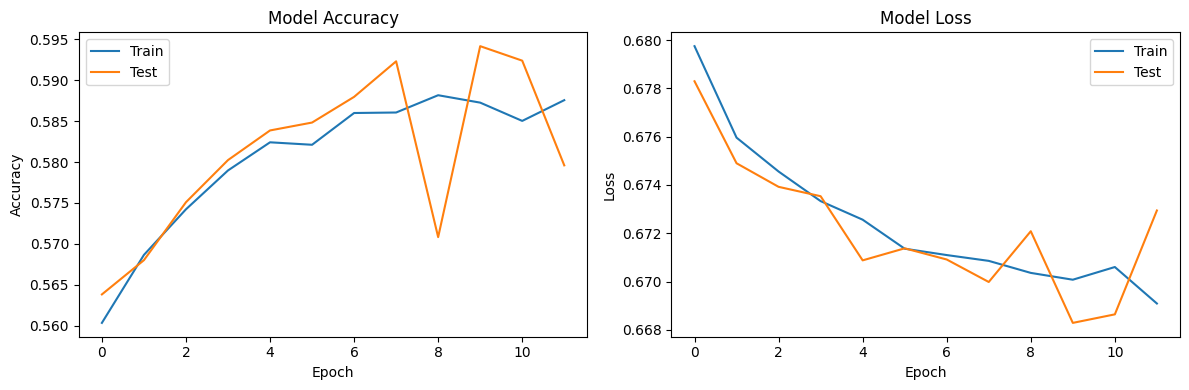

In [20]:
# Evaluate on the test set
loss, accuracy = model.evaluate(X_test, y_test)
print(f'Test Loss: {loss:.4f}')
print(f'Test Accuracy: {accuracy:.4f}')

# Plot training & validation accuracy and loss
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train')
plt.plot(history.history['val_accuracy'], label='Test')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Test')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()

plt.tight_layout()
plt.show()


389/389 ━━━━━━━━━━━━━━━━━━━━ 11s 26ms/step
AUC-ROC: 0.6136


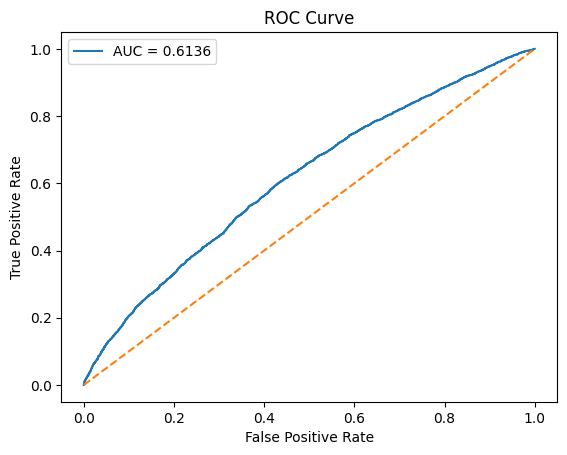

Confusion Matrix:
[[3307 2217]
 [3004 3891]]
Classification Report:
              precision    recall  f1-score   support

           0       0.52      0.60      0.56      5524
           1       0.64      0.56      0.60      6895

    accuracy                           0.58     12419
   macro avg       0.58      0.58      0.58     12419
weighted avg       0.59      0.58      0.58     12419



In [21]:
# Make predictions
y_pred_prob = model.predict(X_test).ravel()
y_pred = (y_pred_prob >= 0.5).astype(int)

# Compute AUC-ROC
from sklearn.metrics import roc_auc_score, roc_curve, confusion_matrix, classification_report

auc = roc_auc_score(y_test, y_pred_prob)
print(f'AUC-ROC: {auc:.4f}')

# Plot ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
plt.figure()
plt.plot(fpr, tpr, label=f'AUC = {auc:.4f}')
plt.plot([0, 1], [0, 1], linestyle='--')
plt.title('ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
print('Confusion Matrix:')
print(cm)

# Classification Report
cr = classification_report(y_test, y_pred)
print('Classification Report:')
print(cr)


Documentation for MIMIC-IV https://mimic.mit.edu/docs/iv/about/concepts/)

Documentation for tables
* https://mimic.mit.edu/docs/iv/modules/hosp/admissions/
* https://mimic.mit.edu/docs/iv/modules/hosp/patients/
* https://mimic.mit.edu/docs/iv/modules/hosp/d_icd_diagnoses/
* https://mimic.mit.edu/docs/iv/modules/hosp/d_icd_procedures/
* https://mimic.mit.edu/docs/iv/modules/hosp/diagnoses_icd/
* https://mimic.mit.edu/docs/iv/modules/hosp/procedures_icd/